<img src="images/generative.jpg" width=30% align=right></img>

# Variational Autoencoder
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Fashion-MNIST](#Fashion-MNIST)
    - [Dataset](#Dataset)
    - [Model](#Model)
    - [Training](#Training)
    - [Coffee break](#Coffee-break)
- [References](#References)

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib notebook

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cuda


## Fashion-MNIST

### Dataset

In [4]:
# NOTE: I would normally assume that the data also must be normalized, but
# that seems to break the model... keep it this way just as a reminder that
# in other scenarios, a list of transforming operators must be composed
transform = transforms.Compose([transforms.ToTensor()])

fashion_mnist_train = datasets.FashionMNIST("datasets/FashionMNIST",
                                            train=True,
                                            transform=transform,
                                            download=True)
train_loader = torch.utils.data.DataLoader(fashion_mnist_train,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=1)

fashion_mnist_test = datasets.FashionMNIST("datasets/FashionMNIST",
                                           train=False,
                                           transform=transform,
                                           download=True)
test_loader = torch.utils.data.DataLoader(fashion_mnist_test,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=1)

In [5]:
def imshow(img, title, figsize):
    npimg = img.detach().numpy()
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

<IPython.core.display.Javascript object>


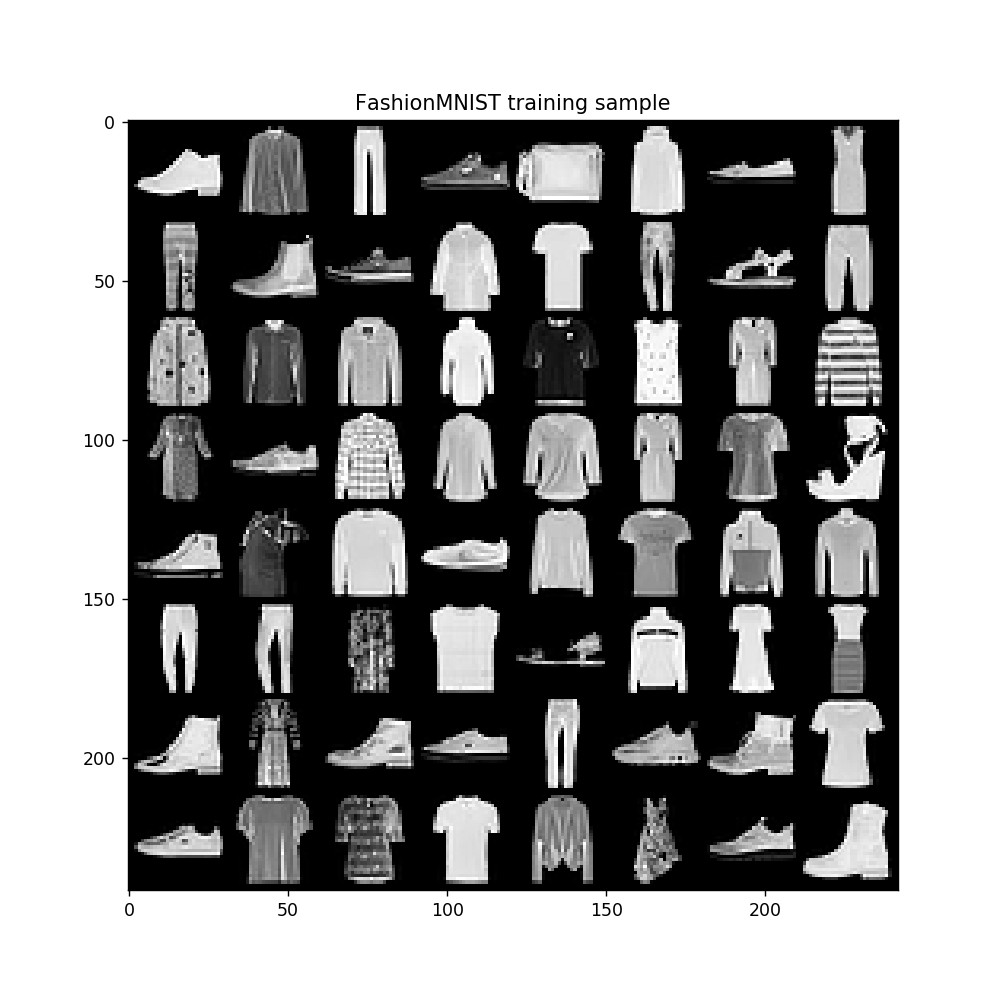

In [6]:
train_iter = iter(train_loader)
images, labels = train_iter.next()
grid = make_grid(images, nrow=8)
imshow(grid, "FashionMNIST training sample", (8, 8))

### Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 7, stride=1, padding=2)
        self.conv2 = nn.Conv2d(8, 16, 7, stride=1, padding=2)
        self.mu = nn.Linear(784, 100)
        self.logvar = nn.Linear(784, 100)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), inplace=True)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = F.leaky_relu(self.conv2(x), inplace=True)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = x.view(x.size(0), -1)
        return self.mu(x), self.logvar(x)

In [8]:
summary(Encoder().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]             400
            Conv2d-2           [-1, 16, 12, 12]           6,288
            Linear-3                  [-1, 100]          78,500
            Linear-4                  [-1, 100]          78,500
Total params: 163,688
Trainable params: 163,688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.62
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(100, 784)
        # NOTE: extra padding for correct output size
        self.conv2 = nn.Conv2d(16, 8, 7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(8, 1, 7, stride=1, padding=3)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1, 16, 7, 7)
        x = F.leaky_relu(self.conv2(F.interpolate(x, scale_factor=2)))
        x = torch.sigmoid(self.conv3(F.interpolate(x, scale_factor=2)))
        return x

In [10]:
summary(Decoder().to(device), (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 784]          79,184
            Conv2d-2            [-1, 8, 14, 14]           6,280
            Conv2d-3            [-1, 1, 28, 28]             393
Total params: 85,857
Trainable params: 85,857
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.33
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_ = self.decoder(z)
        return x_, mu, logvar

In [12]:
summary(VAE().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]             400
            Conv2d-2           [-1, 16, 12, 12]           6,288
            Linear-3                  [-1, 100]          78,500
            Linear-4                  [-1, 100]          78,500
           Encoder-5     [[-1, 100], [-1, 100]]               0
            Linear-6                  [-1, 784]          79,184
            Conv2d-7            [-1, 8, 14, 14]           6,280
            Conv2d-8            [-1, 1, 28, 28]             393
           Decoder-9            [-1, 1, 28, 28]               0
Total params: 249,545
Trainable params: 249,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.95
Estimated Total Size (MB): 0.97
-------------------------------------------

### Training

In [13]:
def vae_loss(x_, x, mu, logvar):
    bce = F.binary_cross_entropy(x_, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

In [14]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters())

In [15]:
def train(model, train_loader, log_freq):
    model.train()
    for i, (x, _) in enumerate(tqdm(train_loader, desc="iters.", leave=False)):
        x = x.to(device)
        optimizer.zero_grad()
        x_, mu, logvar = model(x)
        loss = vae_loss(x_, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % log_freq == 0:
            yield loss.item()

In [16]:
def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            x_, mu, logvar = model(x)
            test_loss += vae_loss(x_, x, mu, logvar)
            if i == 0:
                comparison = torch.cat([x, x_.view(64, 1, 28, 28)])
                save_image(comparison.cpu(), f"results/reconst_{epoch}.png", nrow=4)
    return test_loss

In [17]:
def sample(model, epoch):
    with torch.no_grad():
        z = torch.randn(64, 100).to(device)
        x_ = model.decoder(z).cpu()
        save_image(x_.view(64, 1, 28, 28), f"results/sample_{epoch}.png")

### Coffee break

<IPython.core.display.Javascript object>


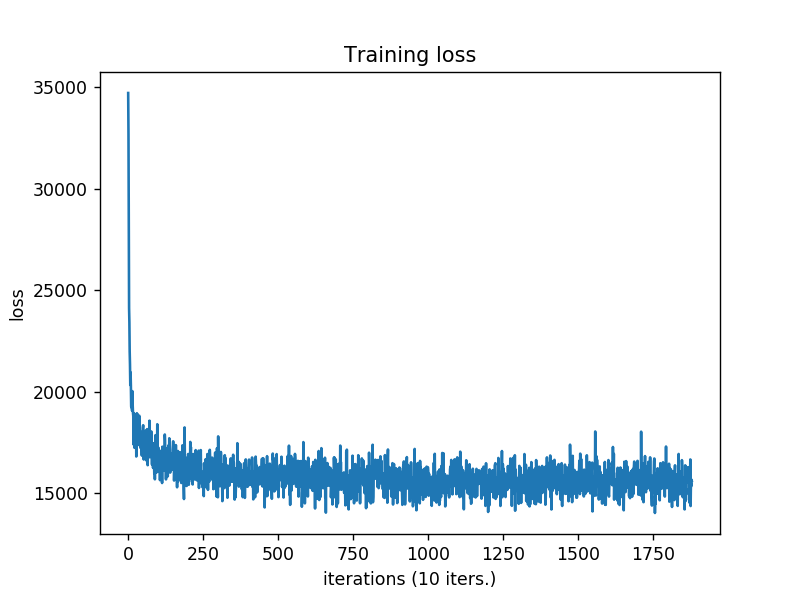

====> Test set loss: 2573032.0


====> Test set loss: 2495489.75


====> Test set loss: 2462769.0


====> Test set loss: 2447024.75


====> Test set loss: 2436634.5


====> Test set loss: 2415846.25


====> Test set loss: 2410041.0


====> Test set loss: 2419965.0


====> Test set loss: 2402710.5


====> Test set loss: 2402222.5


====> Test set loss: 2406698.5


====> Test set loss: 2398482.0


====> Test set loss: 2396941.0


====> Test set loss: 2390593.0


====> Test set loss: 2394476.0


====> Test set loss: 2389950.25


====> Test set loss: 2389092.75


====> Test set loss: 2384866.0


====> Test set loss: 2387072.5


====> Test set loss: 2383252.0



In [18]:
log_freq = 10
export_path = "models/fashion_mnist_vae.pt"
    
fig, ax = plt.subplots()
train_losses = []

def update_fig(data, title, xlabel, ylabel):
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data)
    plt.show()
    fig.canvas.draw()

for epoch in tqdm(range(20), desc="epochs"):
    for train_loss in train(model, train_loader, log_freq):
        train_losses.append(train_loss)
        update_fig(train_losses, 
                   "Training loss", 
                   f"iterations ({log_freq} iters.)", 
                   "loss")
        
    test_loss = test(model, test_loader, epoch)
    print(f"====> Test set loss: {test_loss}")
    sample(model, epoch)

## References